In [2]:
!pip install tensorflow

In [2]:
!pip install tensorflow-gpu

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Image Classification Using VGG - Cat or Dog Kaggle Competition

![catanddog](https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg)

This is a image classification project from [Cat of Dog Kaggel competition](https://www.kaggle.com/c/dogs-vs-cats/overview/description). In this project, I applied convolutional neural network for image classification. And the end, I also applied VGG-16 convolutional neural network by using transfer learning. VGG-16 is a popular deep learning neural network in computer vision, proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)”. The structrue of VGG 16 network is following:
![VGG](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [3]:
import pandas as pd
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,random
import matplotlib.pyplot as plt
print(tf.__version__)

2.15.0


## Prepare Data

The dataset has been split into two parts - training set which contains 25,000 images of dags and cats. In this project, the model is trained on the training set and tested on test set which includes 12,500 images. Since uploading the dataset to google colab is time-consuming. [Yura Istomin](https://medium.com/@yuraist/how-to-upload-your-own-dataset-into-google-colab-e228727c87e9) gives me an idea of uploading the dataset to github and cloning the repository, which works perfectly to use the dataset in Google colab.

In [4]:
! git clone https://github.com/patrick013/Image-Classification-CNN-and-VGG.git

Cloning into 'Image-Classification-CNN-and-VGG'...
remote: Enumerating objects: 37510, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 37510 (delta 43), reused 36 (delta 7), pack-reused 37414
Receiving objects: 100% (37510/37510), 812.51 MiB | 24.91 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Updating files: 100% (50016/50016), done.


In [5]:
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
BATCH_SIZE=64
def get_pathframe(path):
  '''
  Get all the images paths and its corresponding labels
  Store them in pandas dataframe
  '''
  filenames = os.listdir(path)
  categories = []
  paths=[]
  for filename in filenames:
    paths.append(path+filename)
    category = filename.split('.')[0]
    if category == 'dog':
      categories.append(1)
    else:
      categories.append(0)

  df= pd.DataFrame({
      'filename': filenames,
      'category': categories,
      'paths':paths
  })
  return df

In [6]:
df=get_pathframe("Image-Classification-CNN-and-VGG/dataset/dataset/")
df.tail(5)

,filename,category,paths
24995,dog.9474.jpg,1,Image-Classification-CNN-and-VGG/dataset/datas...
24996,cat.1343.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
24997,dog.5666.jpg,1,Image-Classification-CNN-and-VGG/dataset/datas...
24998,cat.3700.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
24999,cat.9422.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...


In [7]:
def load_and_preprocess_image(path):
  '''
  Load each image and resize it to desired shape
  '''
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
  image /= 255.0  # normalize to [0,1] range
  return image

def convert_to_tensor(df):
  '''
  Convert each data and labels to tensor
  '''
  path_ds = tf.data.Dataset.from_tensor_slices(df['paths'])
  image_ds = path_ds.map(load_and_preprocess_image)
  # onehot_label=tf.one_hot(tf.cast(df['category'], tf.int64),2) if using softmax
  onehot_label=tf.cast(df['category'], tf.int64)
  label_ds = tf.data.Dataset.from_tensor_slices(onehot_label)

  return image_ds,label_ds

In [8]:
X,Y=convert_to_tensor(df)
print("Shape of X in data:", X)
print("Shape of Y in data:", Y)

Shape of X in data: <_MapDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>
Shape of Y in data: <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [9]:
dataset=tf.data.Dataset.zip((X,Y)).shuffle(buffer_size=2000)
dataset_train=dataset.take(22500)
dataset_test=dataset.skip(22500)

dataset_train=dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_test=dataset_test.batch(BATCH_SIZE, drop_remainder=True)
dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(64, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int64, name=None))>

### Check Images

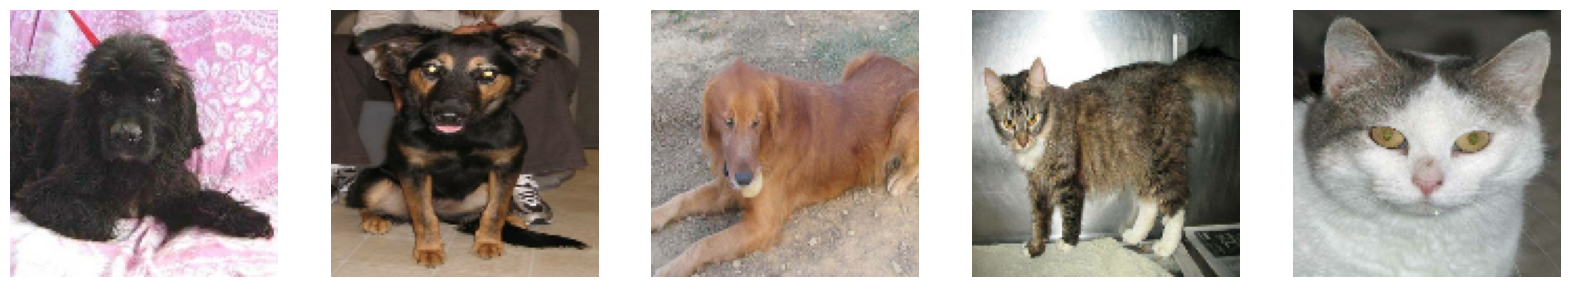

In [10]:
def plotimages(imagesls):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for image,ax in zip(imagesls, axes):
    ax.imshow(image)
    ax.axis('off')

imagesls=[]
for n, image in enumerate(X.take(5)):
  imagesls.append(image)

plotimages(imagesls)

## Convolutional Neural Networks
### Build Network

The architecture of CNN used in this project is shown as follow (PS: fully connected network is not shown on the picture):
![mynetwork](https://raw.githubusercontent.com/patrick013/Image-Classification-CNN-and-VGG/master/pictures/mycnnmodel.png)

In [11]:
def My_CNNmodel():

  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(16, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  opt=tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=opt,
              loss='binary_crossentropy', # loss='categorical_crossentropy' if softmax
              metrics=['accuracy'])

  return model

In [12]:
model=My_CNNmodel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0

### Training

In [13]:
hist = model.fit(dataset_train, epochs=20, validation_data=dataset_test)
model.save("/content/drive/My Drive/DPprojects/DogvsCats/my_model")

Epoch 1/20
351/351 [==============================] - 55s 131ms/step - loss: 0.5732 - accuracy: 0.6960 - val_loss: 0.4930 - val_accuracy: 0.7668
Epoch 2/20
351/351 [==============================] - 66s 182ms/step - loss: 0.4394 - accuracy: 0.7957 - val_loss: 0.3944 - val_accuracy: 0.8217
Epoch 3/20
351/351 [==============================] - 46s 126ms/step - loss: 0.3889 - accuracy: 0.8246 - val_loss: 0.3483 - val_accuracy: 0.8474
Epoch 4/20
351/351 [==============================] - 47s 129ms/step - loss: 0.3432 - accuracy: 0.8477 - val_loss: 0.3165 - val_accuracy: 0.8694
Epoch 5/20
351/351 [==============================] - 47s 129ms/step - loss: 0.3047 - accuracy: 0.8666 - val_loss: 0.3107 - val_accuracy: 0.8754
Epoch 6/20
351/351 [==============================] - 45s 125ms/step - loss: 0.2703 - accuracy: 0.8845 - val_loss: 0.2617 - val_accuracy: 0.8934
Epoch 7/20
351/351 [==============================] - 44s 120ms/step - loss: 0.2320 - accuracy: 0.9017 - val_loss: 0.2565 - val_ac

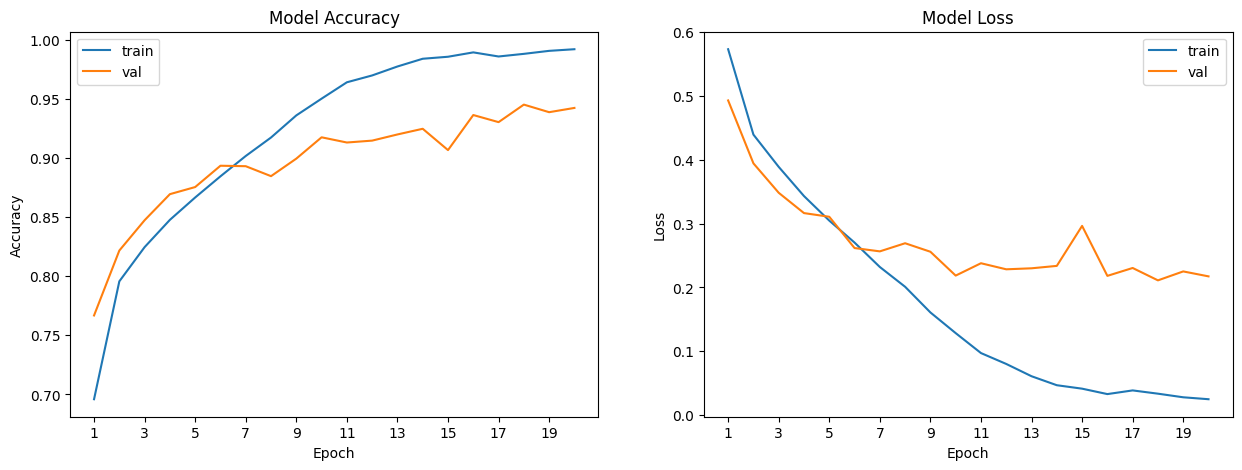

In [15]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    # Use a range object for xtick labels instead of a single number
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1, len(model_history.history[acc])//10))
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    # Use a range object for xtick labels instead of a single number
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1, len(model_history.history['loss'])//10))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(hist)

### Overfitting

Obviously, my model is overfitted! To overcome the problem of overfitting, there are some ways to do:
1. Expand dataset
2. Use regularization
3. Add dropout layers


```
tf.keras.layers.Dropout(0.5)
```
4. Use batchnormalization


```
tf.keras.layers.BatchNormalization()
```



### Evaluation

<ipython-input-16-de1587aefbb2>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(dataset_test)


Test: accuracy = 0.943510  ;  loss = 0.215129 


<ipython-input-16-de1587aefbb2>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred =  model.predict_generator(dataset_test)


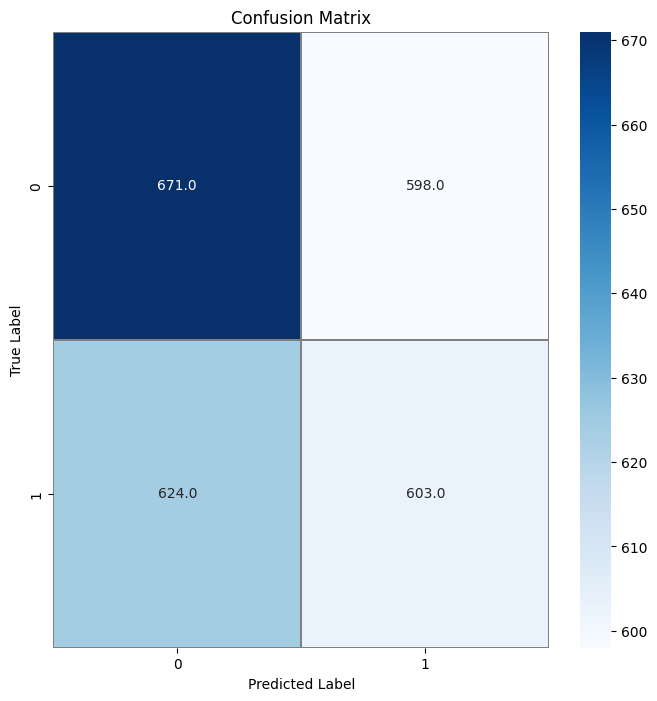

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Predict the values from the validation dataset

loss, accuracy = model.evaluate_generator(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
y_pred =  model.predict_generator(dataset_test)
y_p = np.where(y_pred > 0.5, 1,0)
test_data=dataset_test.unbatch()
y_g=[]
for image, label in  test_data:
  y_g.append(label.numpy())

confusion_mtx = confusion_matrix(y_g, y_p)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Generate a classification report
report = classification_report(y_g, y_p, target_names=['0','1'])
print(report)

              precision    recall  f1-score   support

           0       0.49      0.52      0.50      1262
           1       0.47      0.44      0.45      1234

    accuracy                           0.48      2496
   macro avg       0.48      0.48      0.48      2496
weighted avg       0.48      0.48      0.48      2496



### Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Horizontal Flip

Found 21000 images belonging to 2 classes.


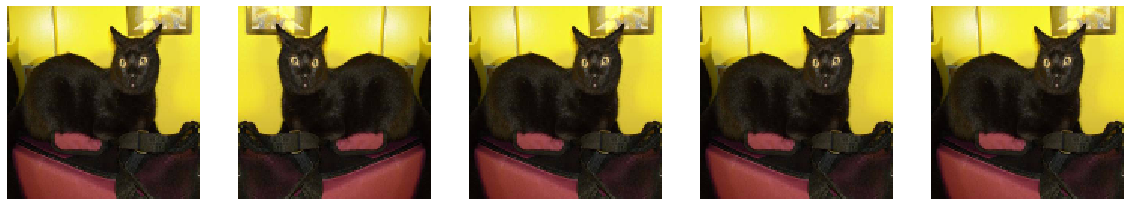

In [ ]:
image_gen_flip = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = image_gen_flip.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory="Image-Classification-CNN-and-VGG/dataset/train_validation/train",
                                                    shuffle=True,
                                                    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

#### Rotation

Found 21000 images belonging to 2 classes.


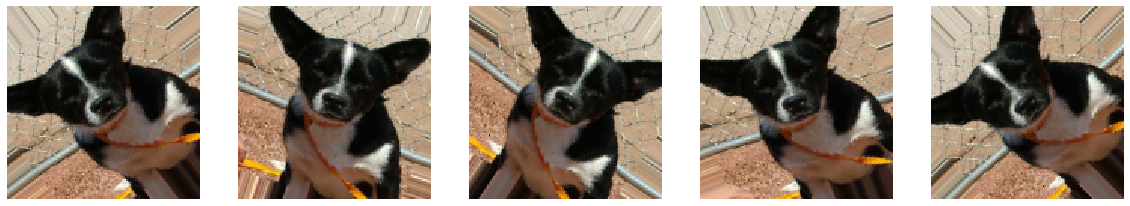

In [ ]:
image_gen_rotate = ImageDataGenerator(rescale=1./255, rotation_range=45)
train_data_gen = image_gen_rotate.flow_from_directory(batch_size=BATCH_SIZE,
                                                       directory="Image-Classification-CNN-and-VGG/dataset/train_validation/train",
                                                       shuffle=True,
                                                       target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

#### Zoom Augmentation

Found 21000 images belonging to 2 classes.


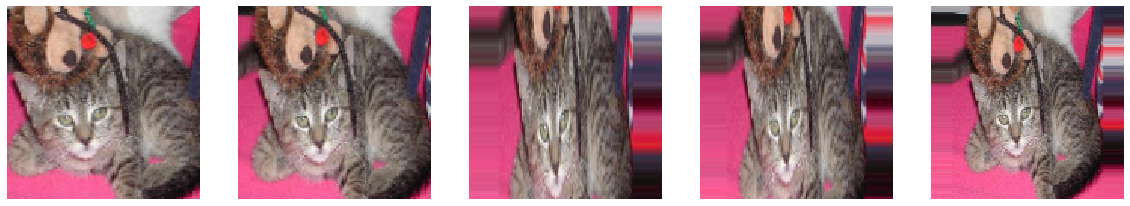

In [ ]:
image_gen_zoom = ImageDataGenerator(rescale=1./255, zoom_range=0.5)
train_data_gen = image_gen_zoom.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory="Image-Classification-CNN-and-VGG/dataset/train_validation/train",
                                                    shuffle=True,
                                                    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

#### Pull Together

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory="Image-Classification-CNN-and-VGG/dataset/train_validation/train",
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')
validation_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory="Image-Classification-CNN-and-VGG/dataset/train_validation/validation",
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')

Found 21000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


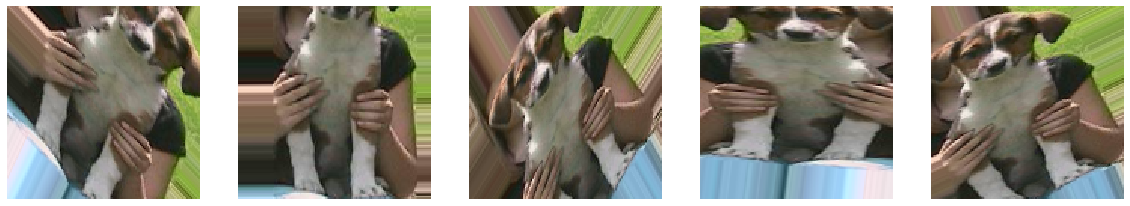

In [ ]:
plotimages([train_data_gen[0][0][0] for i in range(5)])

###Retrain

In [ ]:
def Mynew_CNNmodel():

  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  opt=tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=opt,
              loss='binary_crossentropy', # loss='categorical_crossentropy' if softmax
              metrics=['accuracy'])

  return model

In [ ]:
new_model=Mynew_CNNmodel()
new_hist=new_model.fit_generator(train_data_gen,epochs=20,validation_data=validation_data_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 329 steps, validate for 63 steps
Epoch 1/20
329/329 [==============================] - 166s 506ms/step - loss: 0.7811 - accuracy: 0.6255 - val_loss: 3.1312 - val_accuracy: 0.5027
Epoch 2/20
329/329 [==============================] - 168s 510ms/step - loss: 0.5953 - accuracy: 0.6743 - val_loss: 0.6002 - val_accuracy: 0.6500
Epoch 3/20
329/329 [==============================] - 167s 509ms/step - loss: 0.5799 - accuracy: 0.6881 - val_loss: 0.6275 - val_accuracy: 0.6802
Epoch 4/20
329/329 [==============================] - 168s 510ms/step - loss: 0.5633 - accuracy: 0.7047 - val_loss: 0.5783 - val_accuracy: 0.7063
Epoch 5/20
329/329 [==============================] - 168s 512ms/step - loss: 0.5469 - accuracy: 0.7169 - val_loss: 0.5686 - val_accuracy: 0.6942
Epoch 6/20
329/329 [==============================] - 168s 511ms/step - loss: 0.5336 - accuracy: 0.7259 - val_loss: 0.5235 - val_accuracy: 0.7322
Epoch 7/20
329/329 [===========

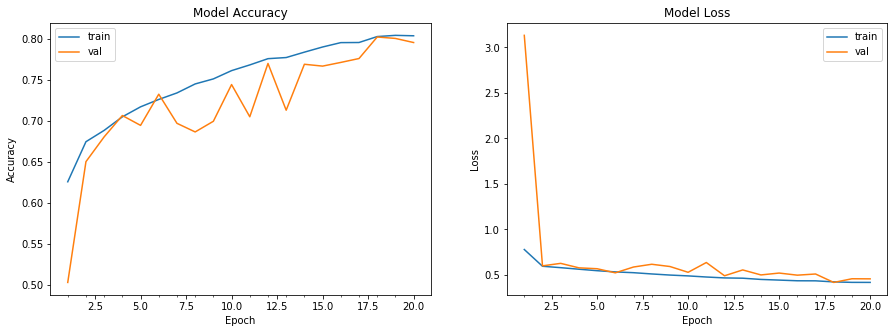

In [ ]:
plot_model_history(new_hist)

## Transfer Learning - VGG16

The output of dataset should be changed!

In [ ]:
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

vggmodel = tf.keras.models.Model(pre_trained_model.input, x)

vggmodel.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

vggmodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

### Training

In [ ]:
vgghist=vggmodel.fit_generator(dataset_train,epochs=20,validation_data=dataset_test)


Train for 351 steps, validate for 39 steps
Epoch 1/20
351/351 [==============================] - 123s 350ms/step - loss: 0.4689 - accuracy: 0.7671 - val_loss: 0.2975 - val_accuracy: 0.8710
Epoch 2/20
351/351 [==============================] - 120s 342ms/step - loss: 0.2836 - accuracy: 0.8783 - val_loss: 0.2389 - val_accuracy: 0.8978
Epoch 3/20
351/351 [==============================] - 121s 344ms/step - loss: 0.2395 - accuracy: 0.8999 - val_loss: 0.2172 - val_accuracy: 0.9054
Epoch 4/20
351/351 [==============================] - 121s 344ms/step - loss: 0.2156 - accuracy: 0.9098 - val_loss: 0.1978 - val_accuracy: 0.9191
Epoch 5/20
351/351 [==============================] - 120s 343ms/step - loss: 0.1963 - accuracy: 0.9181 - val_loss: 0.1826 - val_accuracy: 0.9247
Epoch 6/20
351/351 [==============================] - 120s 342ms/step - loss: 0.1842 - accuracy: 0.9245 - val_loss: 0.1691 - val_accuracy: 0.9307
Epoch 7/20
351/351 [==============================] - 120s 342ms/step - loss: 0.1

In [ ]:
vggmodel.save("/content/drive/My Drive/DPprojects/DogvsCats/vggmodel.h5")

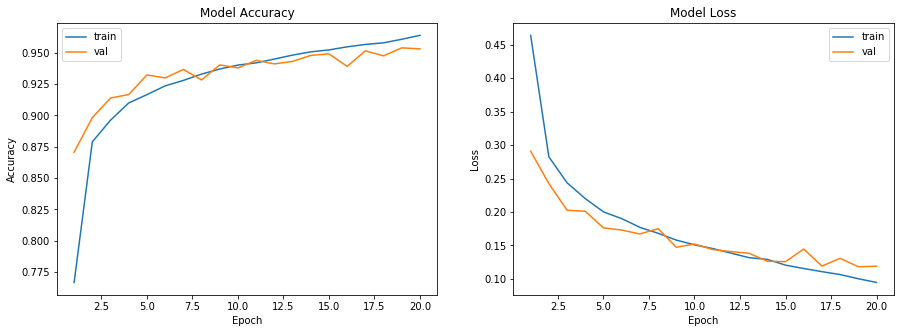

In [ ]:
plot_model_history(vgghist)

### Evaluation


In [ ]:
loss, accuracy = vggmodel.evaluate_generator(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.953125  ;  loss = 0.124623 


In [ ]:
vgg_y_pred =  model.predict_generator(dataset_test)
vgg_y_p = np.where(vgg_y_pred > 0.5, 1,0)

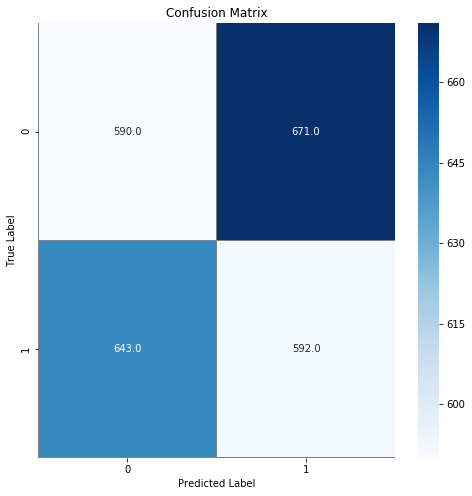

In [ ]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_g, vgg_y_p)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report = classification_report(y_g, vgg_y_p, target_names=['0','1'])
print(report)

              precision    recall  f1-score   support

           0       0.48      0.47      0.47      1261
           1       0.47      0.48      0.47      1235

    accuracy                           0.47      2496
   macro avg       0.47      0.47      0.47      2496
weighted avg       0.47      0.47      0.47      2496



## Summary
Obviously, VGG wins! My model to some degress is overfitted, which means the accuracy on training set is higher than that on validation set. To solve this problem:
1. Batch Normalization
2. Dropout
3. Regularization

### Big Challenge - Loss does not change

The biggest challenge that I met was that there was not a sign that the loss tended to decrease at all after 10 epochs when I was using VGG network. I spent whole night to fix this problem and tried many suggestions online, such as check the dataset labels, reducing the networks and so on. However, it didn't work at all. One of the reason was that I forgot to convert y label to one hot array.